# NN model for recommender system 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.learner import *
from fastai.column_data import *

In [2]:
path='/home/gpu1/work_space/disk_2_work_space2/learning/fastai/courses/dl2/data/data_recommendation/'

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
full_df = ratings.merge(movies,on='movieId',how='left')
print(full_df.shape)
full_df.head()

(20000263, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [6]:
full_df = full_df.iloc[0:100000]

In [7]:
ratings1 = ratings.copy()
ratings = ratings.iloc[0:100000,]
u_uniq = ratings.userId.unique() 
user2idx = {o:i for i,o in enumerate(u_uniq)}
# Take every unique user id and map it to a contiguous user .
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])
# Replace that userid with contiguous number.
# Similarly, we do it for the movies. 
m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [8]:
val_idxs = get_cv_idxs(len(ratings))
n_factors = 10
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
# Getting the Embedding matrix for users and movies check out the output 
# below to know the Embedding dimensionality of User and Movies.

        self.lin1 = nn.Linear(n_factors*2, nh)
# The 1st Linear Layer dimensions is (100,10).
        self.lin2 = nn.Linear(nh, 1)
# The 2nd Linear Layer dimensions is (10,1).
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
# Some drop-outs introduced in both the layer.
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5
    
n_users = ratings.userId.nunique()
n_movies = movies.movieId.nunique()
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)
model

EmbeddingNet(
  (u): Embedding(702, 10)
  (m): Embedding(27278, 10)
  (lin1): Linear(in_features=20, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.5)
)

In [9]:
len(val_idxs)

20000

In [10]:
ratings.shape

(100000, 4)

In [34]:

x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

x_test = ratings.drop(['rating', 'timestamp'],axis=1).loc[ratings.index.isin(val_idxs)]
y_test = ratings['rating'].astype(np.float32).loc[ratings.index.isin(val_idxs)]
#x_test.index = range(len(x_test))
#y_test.index = range(len(y_test))

data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64,
                                         test_df=x_test)

In [35]:
x.shape,x_test.shape

((100000, 2), (20000, 2))

In [36]:
mg = fit(model, data, 3, opt, F.mse_loss,metrics=[f1])

epoch      trn_loss   val_loss   f1                             
    0      0.794131   0.79616    0.0       
    1      0.795568   0.798059   0.0                            
    2      0.787302   0.798658   0.0                            



In [37]:
predicted = (predict(model,data.test_dl))

#### Finding rmse

In [38]:
import math
compdf= pd.DataFrame()
compdf['real']=y_test
compdf['pred']=predicted
compdf['delta'] = compdf.real-compdf.pred
rmse = math.sqrt((compdf.delta*compdf.delta).mean())
print('-I- RMSE = ',rmse)

-I- RMSE =  0.8936801509639049


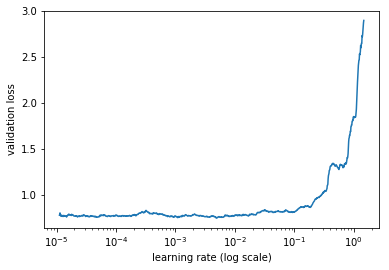

In [58]:

# wrap model in fastai's BasicModel class to gain
# access to the learning rate finder functionality
bm = BasicModel(model)
learner = StructuredLearner(data, bm)
learner.lr_find()
learner.sched.plot()

In [59]:
model

EmbeddingNet(
  (u): Embedding(702, 10)
  (m): Embedding(27278, 10)
  (lin1): Linear(in_features=20, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.5)
)